# Bike Sharing Demand
<h3> Forecast use of a city bikeshare system </h3>
<h4> KwangMyung Yu, Senior Researcher, Korea Electric Power Corporation</h4>

<h3>Problem analysis</h3>

<p> Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.</p><br />
<p> 자전거 공유시스템은 회원가입, 자전거 대여 및 반납이 도시 전체에 자동화된 수단이다. 이 시스템으로 사람들은 자전거를 한지역에서 빌려서 다른지역에 반납할 수있다. 현재 전세계에 500여개의 저전거 공유 프로그램이 존재한다.<br />
이 시스템에서 발생하는 데이터에 연구자들이 관심을 가지고 있다. 사용주기, 출발지, 도착지, 그리고 경과시간이 명확하기 기록되기 때문이다. 자전거 공유시스템은 센서네트워크 기능을 하고, 도시의 유동성을 연구하는데 사용된다. <br />
과거의 자전거 사용패턴과 날씨데이터를 조합하여 워싱턴 D.C. Capital Bikeshare program의 자전거 대여 수요를 예측한다.</p>

<b> 문제 해결을 위해 다음의 단계를 거치게 된다.</b>

# 수정요
1. 데이터 셋 확인  
 - 데이터에 Null 값, 이상치 등이 포함되어 있는지 확인한다.  
2. 탐색적 데이터 분석(Expolatory data analysis)  
 - 피쳐(feature) 값의 특성을 분석하고, 서로 간의 상관관계를 확인한다.  
3. 특성공학(Feature engineering)  
 - 머신러닝 모델의 성능을 향상 시키기 위해 데이터를 전처리한다.  
4. 모델 생성, 학습, 튜닝, 그리고 평가
 - 머신러닝 모델을 생성하여 전처리된 train 데이터로 학습시킨다.  
 - 학습된 모델에 test 데이터를 입력하여 생존자를 예측한다.  
 - 모델의 하이퍼 파라미터를 조정하여 어느정도 성능이 향상되었는지 평가한다.

## 1. 데이터 셋 확인

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

#### 데이터 불러오기

In [2]:
train = pd.read_csv('data/bike_train.csv', parse_dates = ['datetime'])
test = pd.read_csv('data/bike_test.csv', parse_dates = ['datetime'])
print('train : {0}'.format(train.shape))
print('test : {0}'.format(test.shape))

train : (10886, 12)
test : (6493, 9)


#### 데이터 확인

In [3]:
train.head(3) #계절 정보가 잘못 입력되어 있다. 뒤에 수정

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null datetime64[ns]
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.6 KB


In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

결측치는 없다.  
시계열 데이터이며, 타겟 값은 'count'이다.

<b>각 피쳐에 대한 설명은 다음과 같다.</b>
- datetime(날짜/시간) : 날짜 + 타임스탬프(timestamp)  / Object 
- season(계절) :  1 = spring, 2 = summer, 3 = fall, 4 = winter / 정수형
- holiday(공휴일) : 1 = 공휴일, 0 = 공휴일 아님 / 정수형
- workingday(평일) : 1 = 평일, 0 = 주말 또는 공휴일 / 정수형
- weathe(날씨) :  
  1 = Clear, Few clouds, Partly cloudy, Partly cloudy  
  2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  / 정수형
- temp(섭씨온도) : 실수형
- atemp(섭씨 체감온도) : 실수형
- humidity(상대습도) : 정수형
- windspeed(풍속) : 실수형
- casual(비회원 대여수) : 정수형
- registered(회원 대여수) : 정수형
- count(전체 대여수) : 정수형

각 컬럼의 통계정보를 확인한다.

In [7]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## 2. 탐색적 데이터 분석(Explratory data analysis)
 - 피처(컬럼) 별 특성을 살펴본다.
 - 데이터 시각화 라이브러리를 사용한다.

우선 'datetime' 컬럼으로부터 년, 월, 시간 정보를 추출하여 새로운 컬럼 데이터를 만든다.

In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek #월0, 화1 ...일6

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek #월0, 화1 ...일6
print('train : {0}'.format(train.shape))
print('test : {0}'.format(test.shape))

train : (10886, 17)
test : (6493, 14)


계절정보를 수정한다.

In [9]:
def modify_season(month):
    if month in [3, 4, 5]:
        return 1
    if month in [6, 7, 8]:
        return 2
    if month in [9, 10, 11]:
        return 3
    if month in [12, 1, 2]:
        return 4

In [10]:
train['season'] = train.month.apply(modify_season)

### 2.1 Datetime : year, month, day, hour, dayofweek

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Hourly count')]

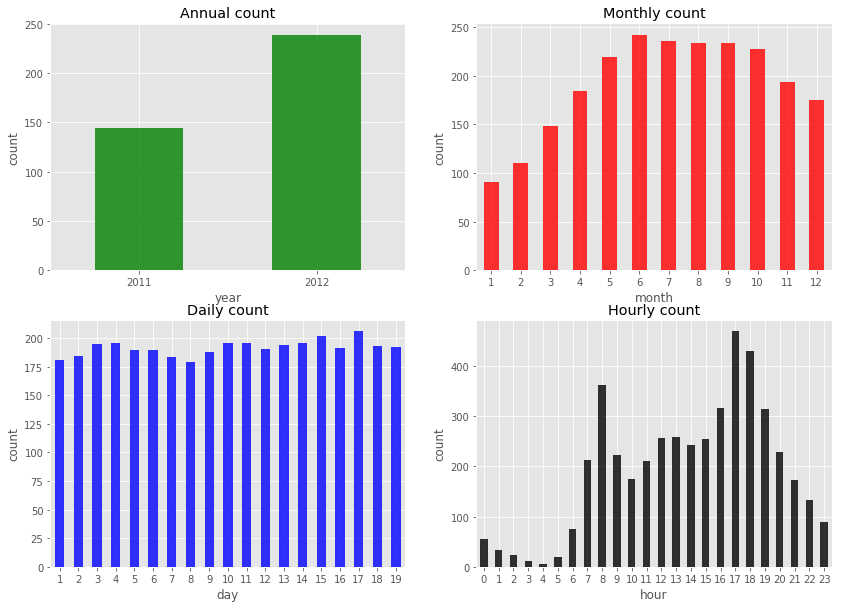

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))
by_year = train.groupby('year').mean()['count']
by_month = train.groupby('month').mean()['count']
by_day = train.groupby('day').mean()['count']
by_hour = train.groupby('hour').mean()['count']

by_year.plot(kind = 'bar', ax = axes[0, 0], color = 'g', 
             alpha = 0.8, rot = 0)
by_month.plot(kind = 'bar', ax = axes[0, 1], color = 'r', 
              alpha = 0.8, rot = 0)
by_day.plot(kind = 'bar', ax = axes[1, 0], color = 'b', 
            alpha = 0.8, rot = 0)
by_hour.plot(kind = 'bar', ax = axes[1, 1], color = 'k', 
             alpha = 0.8, rot = 0)
axes[0, 0].set(ylabel = 'count', title = 'Annual count')
axes[0, 1].set(ylabel = 'count', title = 'Monthly count')
axes[1, 0].set(ylabel = 'count', title = 'Daily count')
axes[1, 1].set(ylabel = 'count', title = 'Hourly count')

In [12]:
train['year-month'] = train['year'].astype('str') +'-'+train['month'].astype('str')
train[['datetime', 'year-month']].head(3)

,datetime,year-month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1


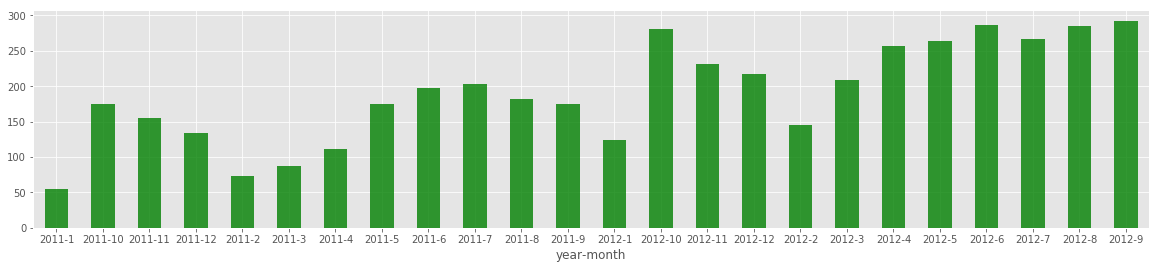

In [13]:
plt.figure(figsize = (20, 4))
by_year_month = train.groupby('year-month').mean()['count']
by_year_month.plot(kind = 'bar',color = 'g', alpha = 0.8, rot = 0)

In [14]:
# 이상.. 확인요

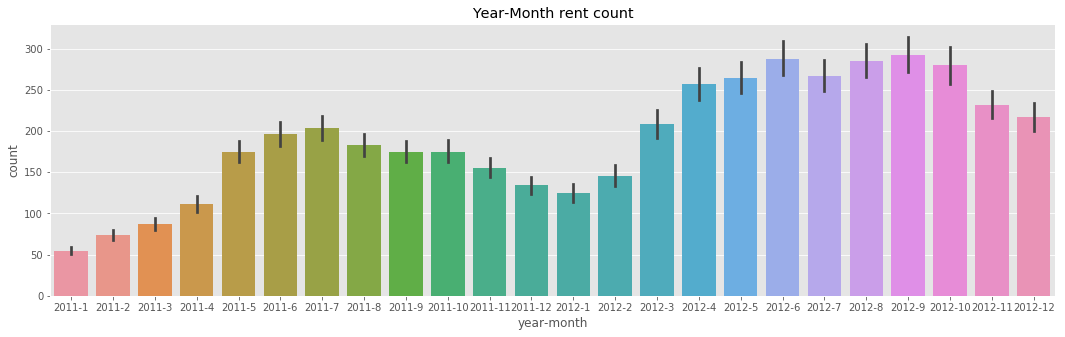

In [15]:
plt.figure(figsize=(18, 5))
sns.barplot(data=train, x="year-month", y="count").set_title("Year-Month rent count")
plt.show()

In [16]:
train = train.drop('year-month', axis = 1)

### 2.2 범주형 데이터와 타겟 간의 상관도 분석 : 
### (season, holiday, workingday, weather) vs count

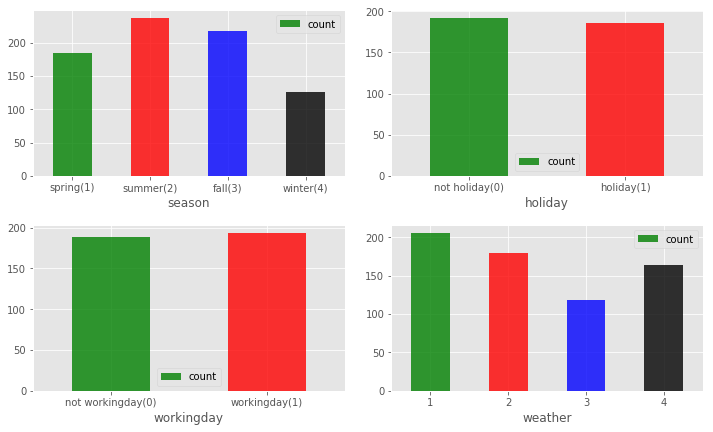

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (12, 7))
by_season = train[['season', 'count']].groupby(['season'], 
            as_index = True)
by_holiday = train[['holiday', 'count']].groupby(['holiday'])
by_workingday = train[['workingday', 'count']].groupby(['workingday'])
by_weather = train[['weather', 'count']].groupby(['weather'])

by_season.mean().plot( kind = 'bar', ax = axes[0,0], alpha = 0.8,
                      rot = 0, color = 'grbk' )
axes[0,0].set_xticklabels(['spring(1)', 'summer(2)', 'fall(3)', 'winter(4)']) 
by_holiday.mean().plot( kind = 'bar', ax = axes[0,1], alpha = 0.8, 
                       rot = 0, color = 'gr')
axes[0,1].set_xticklabels(['not holiday(0)', 'holiday(1)']) 
by_workingday.mean().plot( kind = 'bar', ax = axes[1,0], alpha = 0.8,
                          rot = 0, color = 'gr')
axes[1,0].set_xticklabels(['not workingday(0)', 'workingday(1)']) 
by_weather.mean().plot(kind = 'bar', ax =axes[1,1], alpha = 0.8,
                       rot = 0, color = 'grbk')

plt.subplots_adjust(wspace = 0.15, hspace=0.3)

### ((season, holiday, workingday, weather) + hour) vs count

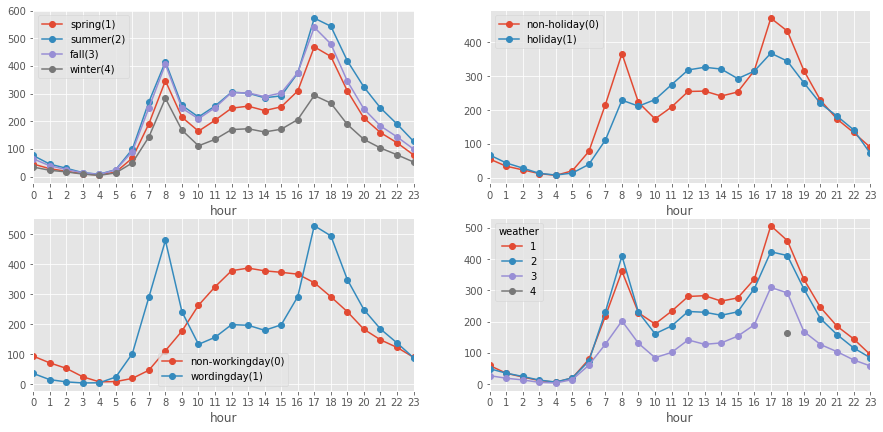

In [18]:
fig, axes = plt.subplots(2, 2, figsize = (15, 7))
by_season_hr = train[['hour', 'season', 'count']].groupby(['hour', 'season'])
by_season_hr.mean()['count'].unstack().plot(ax = axes[0, 0], marker = 'o')
axes[0, 0].set_xticks([i for i in range(0, 24)])
axes[0,0].legend(['spring(1)', 'summer(2)', 'fall(3)', 'winter(4)'])

by_holiday_hr = train[['hour', 'holiday', 'count']].groupby(['hour', 'holiday'])
by_holiday_hr.mean()['count'].unstack().plot(ax = axes[0, 1], marker = 'o')
axes[0, 1].set_xticks([i for i in range(0, 24)])
axes[0, 1].legend(['non-holiday(0)', 'holiday(1)'])

by_workingday_hr = train[['hour', 'workingday', 
                          'count']].groupby(['hour', 'workingday'])
by_workingday_hr.mean()['count'].unstack().plot(ax = axes[1, 0], marker = 'o')
axes[1, 0].set_xticks([i for i in range(0, 24)])
axes[1, 0].legend(['non-workingday(0)', 'wordingday(1)'])

by_weather_hr = train[['hour', 'weather', 'count']].groupby(['hour', 'weather'])
by_weather_hr.mean()['count'].unstack().plot(ax = axes[1, 1], marker = 'o')
axes[1, 1].set_xticks([i for i in range(0, 24)])
plt.show()

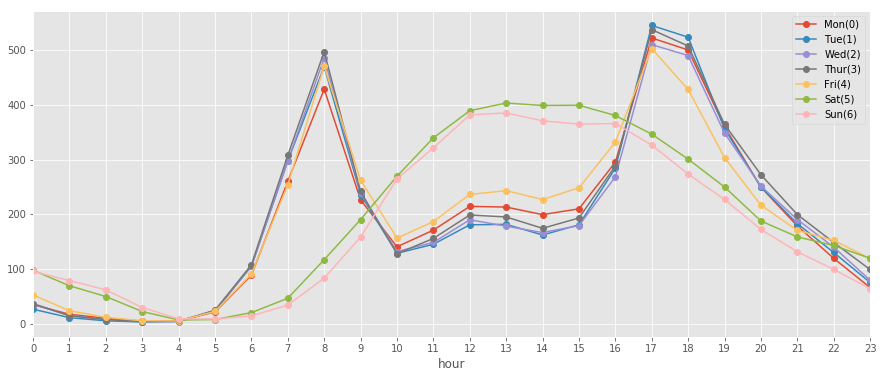

In [19]:
fig, ax = plt.subplots(figsize = (15, 6))
by_weekday_hr = train[['hour', 'dayofweek',
                      'count']].groupby(['hour', 'dayofweek'])
by_weekday_hr.mean()['count'].unstack().plot(ax = ax, marker='o')
ax.set_xticks([i for i in range(0, 24)])
ax.legend(['Mon(0)', 'Tue(1)', 'Wed(2)', 'Thur(3)', 'Fri(4)',
             'Sat(5)', 'Sun(6)'])

### 2.3 숫자형(Numeric) 데이터와 타겟 간의 상관도 분석 : 
### (temp, atemp, humidity, windspeed) vs count

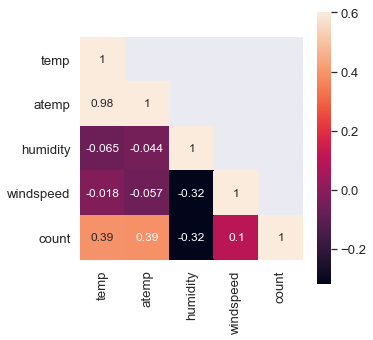

In [20]:
train_numeric = train[['temp', 'atemp', 'humidity', 'windspeed', 
                      'count']]
corr = train_numeric.corr()

mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize = (5, 5))
sns.set(font_scale=1.2)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, mask = mask, 
            annot=True, square = True,annot_kws={"size": 12},
            vmax = .6, cbar = True) #annotation 폰트사이즈

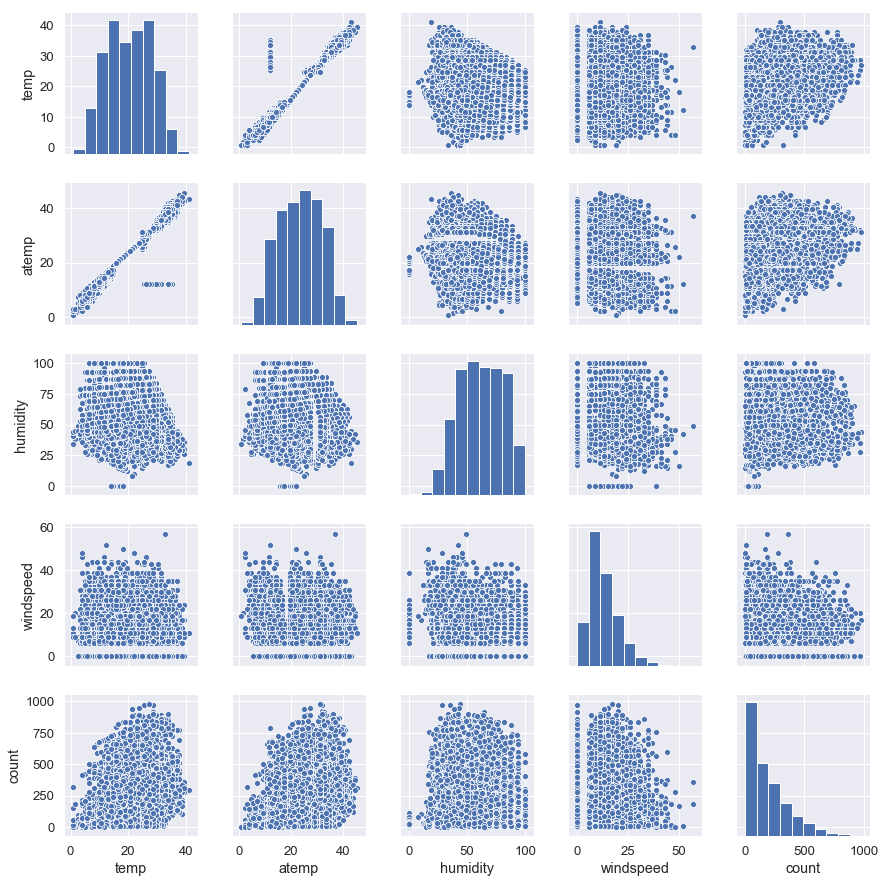

In [21]:
sns.pairplot(train_numeric)

In [22]:
#https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile 참고
# 추가 : temp, humidity와 count의 상관도는 약간 있으므로 일단 둔다.
# windspeed와 count의 상관도는 매우적다.(0.1) => 제거 또는 조정필요
# atemp, temp는 상관도가 커서 모델 생성시 하나만 사용할 것

Text(0.5, 0, 'windspeed')

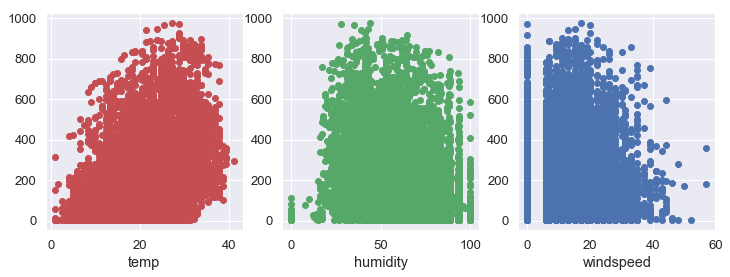

In [23]:
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
#plt.scatter(train['temp'], train['count'], color='r', ax =axes[0])
#plt.scatter(train['humidity'], train['count'], color='g', ax =axes[1])
#plt.scatter(train['windspeed'], train['count'], color='b', ax =axes[2])
axes[0].scatter(train['temp'], train['count'], color='r')
axes[0].set_xlabel('temp')
axes[1].scatter(train['humidity'], train['count'], color='g')
axes[1].set_xlabel('humidity')
axes[2].scatter(train['windspeed'], train['count'], color='b')
axes[2].set_xlabel('windspeed')

In [24]:
numofWind0 = train[train['windspeed']==0]['windspeed'].shape[0]
print('Number of windspeed 0 : {0}'.format(numofWind0))

Number of windspeed 0 : 1313


windspeed에 0 값이 많이 포함되어 있다.(1313개)

### 2.4 숫자형 데이터 분포 확인 : Boxplot, Histogram

**Boxplot**

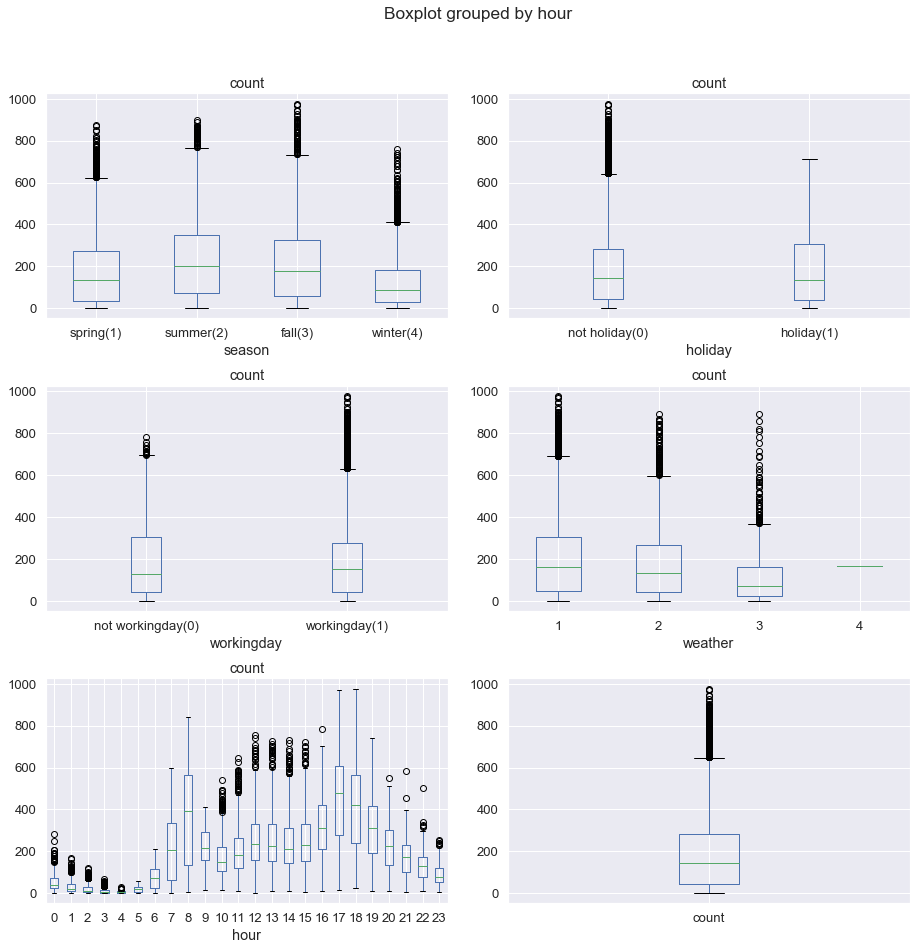

In [25]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
by_season = train[['season', 'count']].groupby(['season'], 
            as_index = True)
by_holiday = train[['holiday', 'count']].groupby(['holiday'])
by_workingday = train[['workingday', 'count']].groupby(['workingday'])
by_weather = train[['weather', 'count']].groupby(['weather'])
by_hour = train[['hour', 'count']].groupby(['hour'])

train.boxplot(column = ['count'], by = 'season', ax = axes[0,0])
axes[0,0].set_xticklabels(['spring(1)', 'summer(2)', 'fall(3)', 'winter(4)']) 
train.boxplot(column = ['count'], by = 'holiday', ax = axes[0,1])
axes[0,1].set_xticklabels(['not holiday(0)', 'holiday(1)']) 
train.boxplot(column = ['count'], by = 'workingday', ax = axes[1, 0])
axes[1,0].set_xticklabels(['not workingday(0)', 'workingday(1)']) 
train.boxplot(column = ['count'], by = 'weather', ax = axes[1, 1])
train.boxplot(column = ['count'], by = 'hour', ax = axes[2, 0])
train.boxplot(column = ['count'], ax = axes[2, 1])

plt.subplots_adjust(wspace = 0.15, hspace=0.3)

**Histogram**

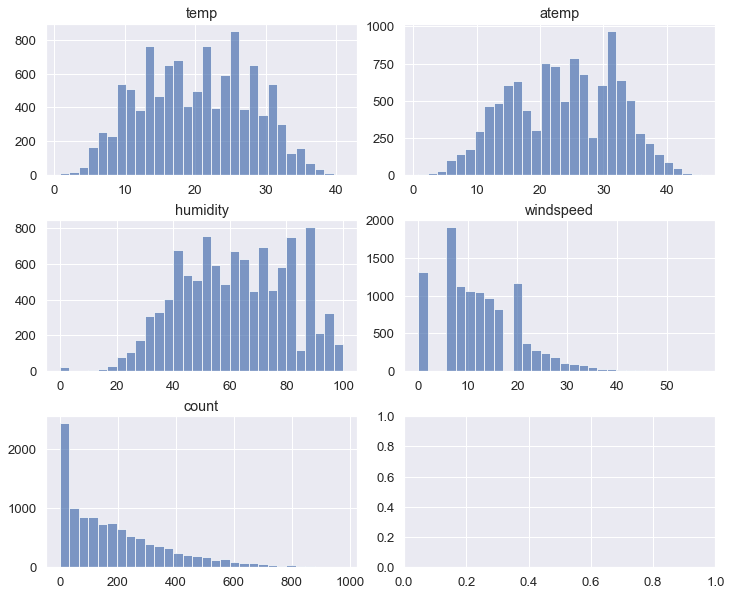

In [26]:
fig, axes = plt.subplots(3, 2, figsize = (12, 10))
train['temp'].hist(bins = 30, ax = axes[0, 0], alpha = 0.7)
axes[0,0].set_title('temp')
train['atemp'].hist(bins = 30, ax =axes[0,1], alpha = 0.7)
axes[0,1].set_title('atemp')
train['humidity'].hist(bins = 30, ax =axes[1, 0], alpha = 0.7)
axes[1,0].set_title('humidity')
train['windspeed'].hist(bins = 30, ax = axes[1, 1], alpha = 0.7)
axes[1,1].set_title('windspeed')
train['count'].hist(bins = 30, ax = axes[2, 0], alpha = 0.7)
axes[2,0].set_title('count')
plt.subplots_adjust(wspace = 0.15, hspace=0.3)

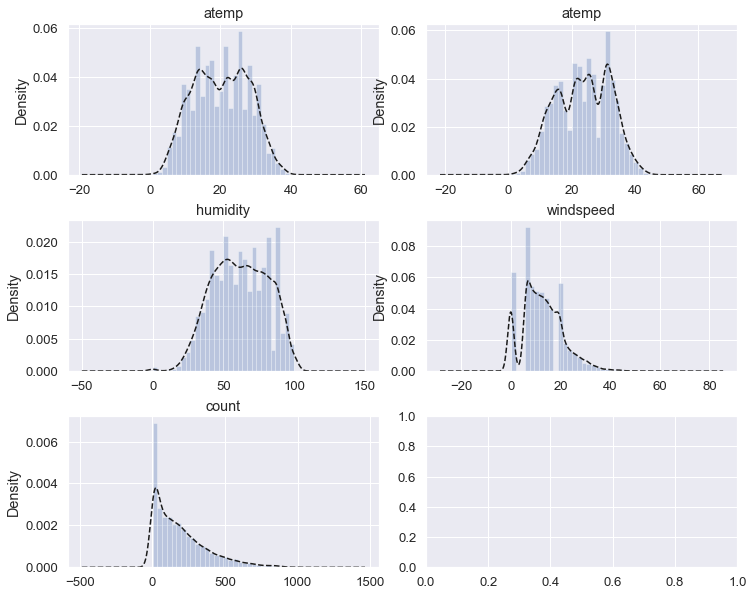

In [27]:
fig, axes = plt.subplots(3, 2, figsize = (12, 10))
train['temp'].plot(kind = 'hist', bins = 30, alpha = 0.3, density = True, 
                   ax = axes[0,0])
train['temp'].plot(kind= 'kde', style = 'k--',ax = axes[0,0])
axes[0,0].set_title('atemp')
train['atemp'].plot(kind = 'hist', bins = 30, alpha = 0.3, density = True, 
                   ax = axes[0,1])
train['atemp'].plot(kind= 'kde', style = 'k--',ax = axes[0,1])
axes[0,1].set_title('atemp')
train['humidity'].plot(kind = 'hist', bins = 30, alpha = 0.3, density = True, 
                   ax = axes[1,0])
train['humidity'].plot(kind= 'kde', style = 'k--',ax = axes[1,0])
axes[1,0].set_title('humidity')
train['windspeed'].plot(kind = 'hist', bins = 30, alpha = 0.3, density = True, 
                   ax = axes[1,1])
train['windspeed'].plot(kind= 'kde', style = 'k--',ax = axes[1,1])
axes[1,1].set_title('windspeed')
train['count'].plot(kind = 'hist', bins = 30, alpha = 0.3, density = True, 
                   ax = axes[2,0])
train['count'].plot(kind= 'kde', style = 'k--',ax = axes[2,0])
axes[2,0].set_title('count')
plt.subplots_adjust(wspace = 0.15, hspace=0.3)

**타겟변수(count) 살펴보기**

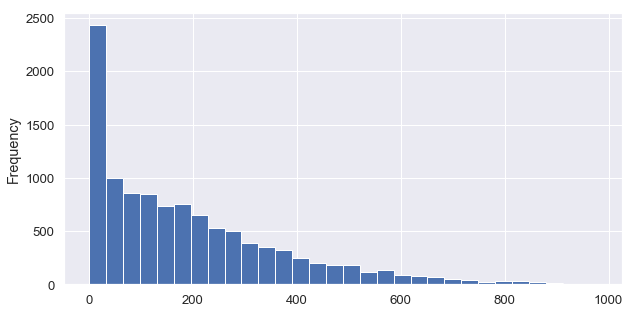

In [28]:
fig, ax = plt.subplots(figsize = (10, 5))
train['count'].plot(kind = 'hist', bins = 30)

In [29]:
print('skew : {0: .3f}'.format(train['count'].skew()))
print('kurt : {0: .3f}'.format(train['count'].kurt()))

skew :  1.242
kurt :  1.300


- 왜도(Skewness) : 오른쪽 꼬리가 길수록 값이 큼  
- 첨도(kurtosis) : 첨도 값(K)이 3에 가까울 경우, 정규 분포에 가까움.  
 - (K <3), 정규 분포보다 더 평탄    
 - (K> 3), 정규 분포보다 더 표족함  
- 정규분표 : 왜도 0, 첨도 3인 분포  

count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다.  
- 대안  
**outlier data를 제거하고 log를 취함**

참고 : https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

## 3. 특성공학(Feature Engineering)

- 결측치 처리
- 이상치 처리
- 정규화
- 범주형 데이터 인코딩
- 피처선정

In [30]:
print('train.shape: {0}'.format(train.shape))
print('test.shape: {0}'.format(test.shape))

train.shape: (10886, 17)
test.shape: (6493, 14)


In [31]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.496326,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,3.013963
std,1.116106,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,1.250000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,1.000000
50%,2.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,3.000000
75%,3.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,6.000000


In [32]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,2011.503619,6.565070,25.224550,11.555367,3.007239
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.500025,3.429462,3.339411,6.912526,1.997714
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,2011.000000,1.000000,20.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,2011.000000,4.000000,22.000000,6.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,2012.000000,7.000000,25.000000,12.000000,3.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,2012.000000,10.000000,28.000000,18.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,2012.000000,12.000000,31.000000,23.000000,6.000000


In [33]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


### 3.1 결측치 처리

In [34]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
dayofweek     0
dtype: int64

In [35]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
month         0
day           0
hour          0
dayofweek     0
dtype: int64

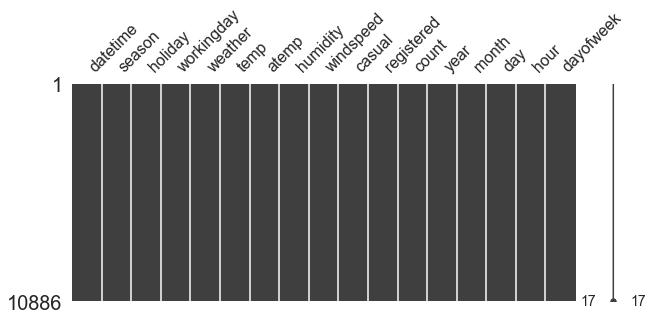

In [36]:
msno.matrix(train, figsize= (10, 4))

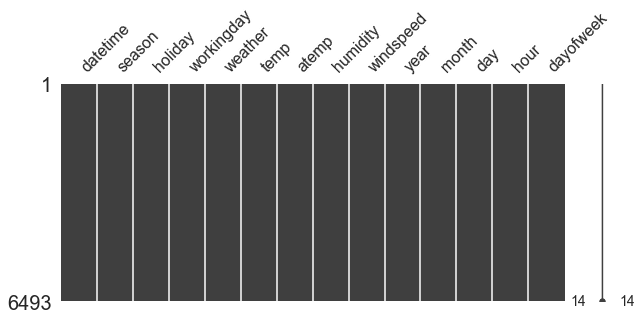

In [37]:
msno.matrix(test, figsize= (10, 4))

결측치 없음.

### 3.2 이상치 처리

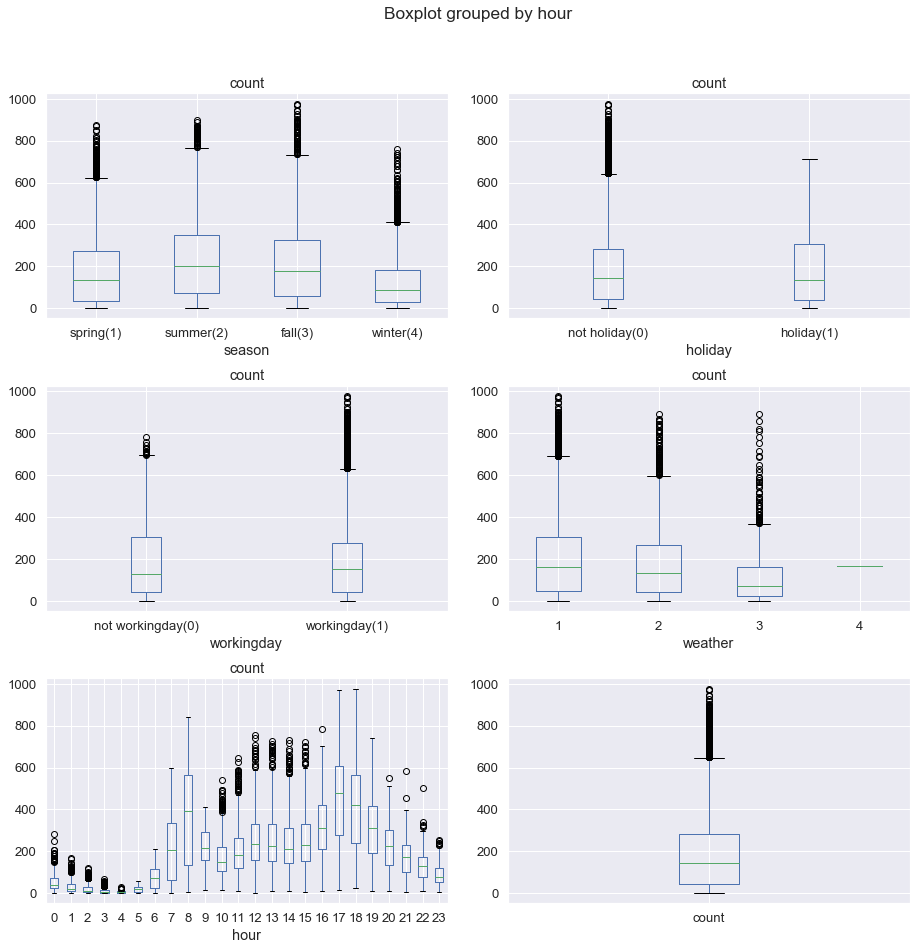

In [38]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
by_season = train[['season', 'count']].groupby(['season'], 
            as_index = True)
by_holiday = train[['holiday', 'count']].groupby(['holiday'])
by_workingday = train[['workingday', 'count']].groupby(['workingday'])
by_weather = train[['weather', 'count']].groupby(['weather'])
by_hour = train[['hour', 'count']].groupby(['hour'])

train.boxplot(column = ['count'], by = 'season', ax = axes[0,0])
axes[0,0].set_xticklabels(['spring(1)', 'summer(2)', 'fall(3)', 'winter(4)']) 
train.boxplot(column = ['count'], by = 'holiday', ax = axes[0,1])
axes[0,1].set_xticklabels(['not holiday(0)', 'holiday(1)']) 
train.boxplot(column = ['count'], by = 'workingday', ax = axes[1, 0])
axes[1,0].set_xticklabels(['not workingday(0)', 'workingday(1)']) 
train.boxplot(column = ['count'], by = 'weather', ax = axes[1, 1])
train.boxplot(column = ['count'], by = 'hour', ax = axes[2, 0])
train.boxplot(column = ['count'], ax = axes[2, 1])

plt.subplots_adjust(wspace = 0.15, hspace=0.3)

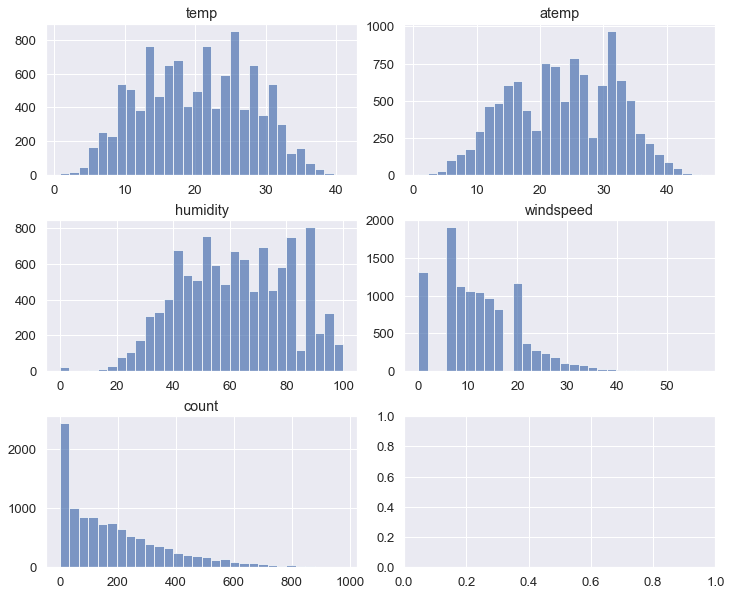

In [39]:
fig, axes = plt.subplots(3, 2, figsize = (12, 10))
train['temp'].hist(bins = 30, ax = axes[0, 0], alpha = 0.7)
axes[0,0].set_title('temp')
train['atemp'].hist(bins = 30, ax =axes[0,1], alpha = 0.7)
axes[0,1].set_title('atemp')
train['humidity'].hist(bins = 30, ax =axes[1, 0], alpha = 0.7)
axes[1,0].set_title('humidity')
train['windspeed'].hist(bins = 30, ax = axes[1, 1], alpha = 0.7)
axes[1,1].set_title('windspeed')
train['count'].hist(bins = 30, ax = axes[2, 0], alpha = 0.7)
axes[2,0].set_title('count')
plt.subplots_adjust(wspace = 0.15, hspace=0.3)

- count 값의 경우 왜도(skewness)가 큰 형태이다. 이상치가 오른쪽에 많이 분포되어 있다. Outer Quartile Limit을 초과하는 값들이 많이 확인된다.
- 시간대별 boxplot에서 7~8시대와 17~18시대 중간값들이 상대적으로 크다. 학생들이나 회사원들의 사용량이 많은 시간대인 것으로 추정된다.
- workingday에 outlier가 상대적으로 많다.

**count**

- 참고 : https://ko.wikipedia.org/wiki/68-95-99.7_%EA%B7%9C%EC%B9%99  
- 68-95-99.7 규칙(3시그마 규칙)  
통계학 경험규칙에 따르면, 평균에서 양쪽으로 3표준편차 범위에 모든 값(99.7%)이 포함된다고 한다.

In [40]:
trainWithoutOutliers = train[np.abs(train['count']-train['count'].mean())\
             <= (3*train['count'].std())]
print('the number of train data(raw data): {}'.format(train.shape[0]))
print('the number of train data(new data): {}'.format(trainWithoutOutliers.shape[0]))

the number of train data(raw data): 10886
the number of train data(new data): 10739


이상치를 제거한 데이터를 사용한다.

In [41]:
train = trainWithoutOutliers
train.reset_index(inplace = True)
train.drop('index', inplace = True, axis = 1)

**windspeed**

Number of windspeed 0 : 1297


Text(0.5, 1.0, 'test windspeed')

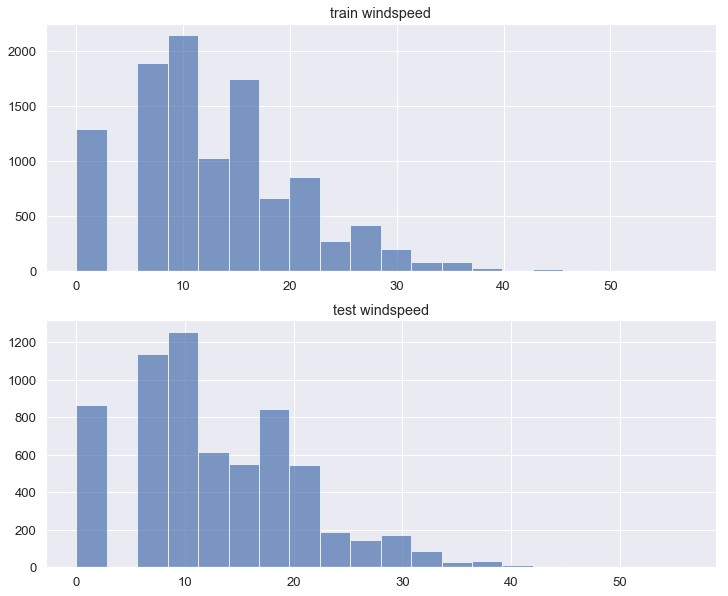

In [42]:
numofWind0 = train[train['windspeed']==0]['windspeed'].shape[0]
print('Number of windspeed 0 : {0}'.format(numofWind0))

fig, axes = plt.subplots(2, 1, figsize = (12, 10))
train['windspeed'].hist(bins = 20, ax = axes[0], alpha = 0.7)
axes[0].set_title('train windspeed')
test['windspeed'].hist(bins = 20, ax = axes[1], alpha = 0.7)
axes[1].set_title('test windspeed')

풍속 데이터에 0 값이 많다.  
0 대신 평균 값을 대입할 수도 있지만, 예측성능 향상에 도움이 되지 않는다.  
날씨정보로 풍속을 예측하는 모델을 사용하여 값을 대체한다.

In [43]:
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [44]:
from sklearn.ensemble import RandomForestRegressor
dataWind0 = data[data['windspeed']==0]
dataWindNot0 = data[data['windspeed']!=0] #학습데이터
windCols = ["season","weather","humidity","month","temp","year","atemp"]
rf = RandomForestRegressor()
rf.fit(dataWindNot0[windCols], dataWindNot0['windspeed'])
wind0Values = rf.predict(dataWind0[windCols])
dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [45]:
train = data[pd.notnull(data['count'])].sort_values(by=['datetime'])
test = data[~pd.notnull(data['count'])].sort_values(by=['datetime'])
test = test.drop(['casual', 'registered', 'count'], axis = 1)

train.reset_index(inplace = True)
train.drop('index', inplace = True, axis = 1)
test.reset_index(inplace = True)
test.drop('index', inplace = True, axis = 1)

In [46]:
print('train.shape: {0}'.format(train.shape))
print('test.shape: {0}'.format(test.shape))

train.shape: (10739, 17)
test.shape: (6493, 14)


In [47]:
train[train['windspeed']==0]['windspeed'].shape[0]

0

In [48]:
test[test['windspeed']==0]['windspeed'].shape[0]

0

### 3.3 정규화

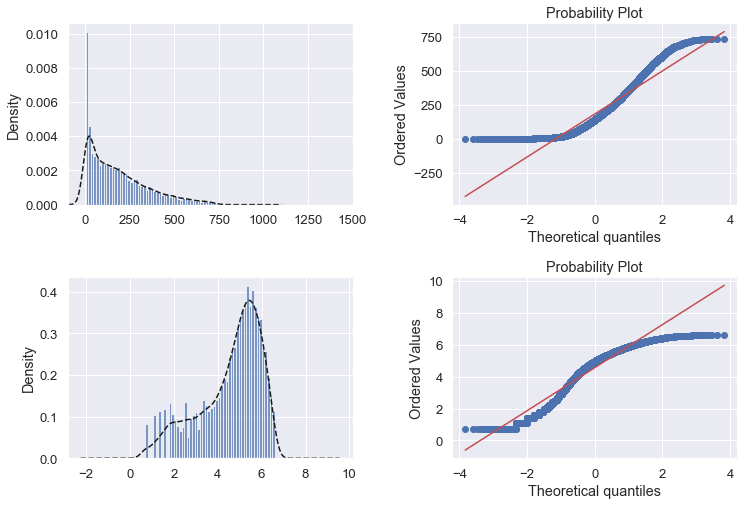

In [49]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
train['count'].plot(kind = 'hist', bins = 50, ax = axes[0, 0], 
                    alpha = 0.7, density = True)
train['count'].plot(kind = 'kde', style = 'k--', ax = axes[0, 0])
axes[0, 0].set_xlim(-100, 1500) #plt에서 사용하려면 plt.xlim() 그러나 전체가 변경됨
# 주의 axes[0, 0]을 입력하면 에러 발생

np.log1p(train['count']).plot(kind = 'hist', bins = 50, ax = axes[1, 0], 
                    alpha = 0.7, density = True)
np.log1p(train['count']).plot(kind = 'kde', style = 'k--', ax = axes[1, 0])

sp.stats.probplot(train['count'], plot= axes[0, 1])
sp.stats.probplot(np.log1p(train['count']), plot= axes[1, 1])
plt.subplots_adjust(wspace = 0.35, hspace=0.4)

Q-Q 플롯(Quantaile-Quantile) 또는 Probability 플롯은 어떤 확률변수의 분포가 정규분포인지 아닌지 확인하는 정규분포 검정(normality test)에 자주사용된다.  
위의 우측 그림을 보면 로그화를 통해 정규화 정도가 어느정도 개선된 것을 확인할 수가 있다.

모델 학습시에 적용하기로 한다.

### 3.4 인코딩

범주형 데이터의 one-hot 인코딩은 효과적이다.  
**하지만 인코딩으로 인해 sparesity가 커져서 트리기반 앙상블 모델에 부적합하다.**  
**(one-hot 인코딩이 낮은 level을 가지는(low-cardinality) 범주형 변수에는 효과적이다.)**

여기서는 범주형 데이터 타입을 'category'로만 조정해준다.

In [50]:
categorical_features = ["season","holiday","workingday","weather",
                        "dayofweek","month","year","hour"]

numerical_features = ["temp","humidity","windspeed","atemp"]

drop_features = ['casual',"count","datetime","registered"]

In [51]:
for var in categorical_features:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

### 3.5 피처선정

In [52]:
X = train[categorical_features + numerical_features]
y = train['count']

X_test = test[categorical_features + numerical_features]

## 4. 모델 생성, 학습, 튜닝, 그리고 평가

### 4.1 환경구축 및 평가지표 확인

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings; warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor
from sklearn.svm import SVR

plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 5)
%matplotlib inline

**평가지표 : RMSLE**  
과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다. 

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

* \\({n}\\) is the number of hours in the test set
* \\(p_i\\) is your predicted count
* \\(a_i\\) is the actual count
* \\(\log(x)\\) is the natural logarithm

* 좀 더 자세한 설명은 : [RMSLE cost function](https://www.slideshare.net/KhorSoonHin/rmsle-cost-function)

* 잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
* 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.
* 값이 작을 수록 오류가 적다는 의미를 나타낸다.

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Logarithms.svg/456px-Logarithms.svg.png)
이미지 출처 : 위키피디아 https://ko.wikipedia.org/wiki/로그

rmsle 계산함수를 만든다.

In [54]:
def rmsle(y_hat, y, convert_exp = True):
    if convert_exp:
        y_hat = np.exp(y_hat),
        y = np.exp(y)
    
    y_hat = np.array(y_hat)
    y = np.array(y) #어레이 형태로 바꿔줌
    
    log_y_hat = np.log(y_hat + 1)
    log_y = np.log(y + 1)
    
    temp = (log_y_hat - log_y)**2
    
    return np.sqrt(np.mean(temp))

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [55]:
X_train = X.values
y_train_log = np.log1p(y.values)

### 4.2 모델 평가하기 : Baselime 모델 선정

In [56]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('SVR', SVR()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
#models.append(('XGBR', XGBRegressor()))
models

[('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False)),
 ('DT',
  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best')),
 ('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False)),
 ('ABR',
  AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
           n_estimators=50, random_state=None)),
 ('GBR',
  GradientBoos

In [57]:
num_folds = 10
seed = 7

In [58]:
results = []; names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train_log, cv = kfold,
                                scoring = rmsle_scorer)
    scores = cv_results
    results.append(scores)
    names.append(name)
    print('{0:5s}: {1:.5f} ({2: .5f})'.format(name, 
                            scores.mean(), scores.std()))

LR   : 0.98807 ( 0.06510)
DT   : 0.53003 ( 0.13375)
RF   : 0.39071 ( 0.09386)
ABR  : 0.67770 ( 0.04820)
GBR  : 0.39827 ( 0.05232)


## 추가적으로 해줄부분

**1. temp 데이터를 카테고리로 구분해볼 것**  
  https://www.kaggle.com/rajmehra03/bike-sharing-demand-rmsle-0-3194  

**2. Xgboost 사용해보기**  
  https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile  

**3. 피처 조정하면서 성능평가**

**4. 하이퍼 파라미터 튜닝**